# <center> Modèle intelligent pour la détection des masques</center>

## Partie 1 : Base de données, Analyse et Préparation

In [1]:
import pandas as pd
import numpy as np 
import os
import struct
import sys
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image 
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
directory = "/content/drive/MyDrive/Mask_Data/with_mask/"

X = []
# liste pour enregistrer les labels
y = []
# l va servir à numéroter les labels : dans la boucle, l s'incrémente de 1 à chaque passage 
l = 1

for x in tqdm(os.listdir(directory)):
    image = cv2.imread(directory + x)
    # on resize
    image = cv2.resize(image,(224,224), interpolation = cv2.INTER_AREA)
    X.append(image)
    y.append(l)

100%|██████████| 755/755 [00:18<00:00, 41.09it/s]


In [3]:
directory = "/content/drive/MyDrive/Mask_Data/without_mask/"


l= 0

for x in tqdm(os.listdir(directory)):
    image = cv2.imread(directory + x)
    # on resize
    image = cv2.resize(image,(224,224), interpolation = cv2.INTER_AREA)
    X.append(image)
    y.append(l)

100%|██████████| 753/753 [00:13<00:00, 54.05it/s]


In [4]:
X = np.array(X)/255
y = np.array(y)

In [5]:
# to_categorical

y_cat = tf.keras.utils.to_categorical(y, num_classes=None)

## Séparation du jeu de données

In [6]:
# train_test_split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.20)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [7]:
# Création du jeu de validation
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=1)
X_train_val.shape, X_val.shape, y_train_val.shape, y_val.shape

X_train_val = np.array(X_train_val)
y_train_val = np.array(y_train_val)

In [8]:
# # Séparation du jeu de donnée
# from sklearn.model_selection import train_test_split
# X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y_cat, test_size = 0.2, random_state = 0)
# X_train_cat.shape, X_test_cat.shape, y_train_cat.shape, y_test_cat.shape

In [9]:
# # Création du jeu de validation
# X_train_val_cat, X_val_cat, y_train_val_cat, y_val_cat = train_test_split(X_train_cat, y_train_cat, test_size=0.10, random_state=1)
# X_train_val_cat.shape, X_val_cat.shape, y_train_val_cat.shape, y_val_cat.shape

In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [13]:
## Data transformation

from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
        
        # data augmentation
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 1.1,
        horizontal_flip = True
        )

data_gen = train_data_generator.flow(X_train, y_train, batch_size = 64)

TypeError: ignored

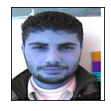

In [14]:
class_names = ["0", "1"]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])

    plt.xlabel(class_names[y_train[i]])
plt.show()

## Partie 2 : Architecture CNN sur Tensorflow


In [15]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizer_v2 import adam as adam_v2
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16

In [16]:
# Modèle VGG16
# base_model = VGG16(weights='imagenet', include_top=True) 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [17]:
num_classes = 2

model = tf.keras.Sequential([
    base_model,
    Flatten(),  
    Dense(4096,activation='relu'),
    Dense(4096, activation='relu'),
    Dense(num_classes, activation='softmax')   
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 2)                 8194      
                                                                 
Total params: 134,268,738
Trainable params: 119,554,050
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
model.compile(optimizer='adam', 
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Compile le modèle
# model.compile(
#     loss="sparse_categorical_crossentropy",    #quand il y a plus d'un label(classes)
#     optimizer="Adam",                #descente de gradient
#     metrics=["accuracy"])      #performance

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model.fit(data_gen,  
                    epochs=5, 
                    validation_data = (X_train_val, y_train_val), 
                    callbacks=[checkpoint])

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 [==============================] - ETA: 0s - loss: 8.2053 - accuracy: 0.5464
Epoch 1: val_accuracy improved from -inf to 0.66544, saving model to vgg16_1.h5
19/19 [==============================] - 68s 3s/step - loss: 8.2053 - accuracy: 0.5464 - val_loss: 0.4848 - val_accuracy: 0.6654
Epoch 2/5
19/19 [==============================] - ETA: 0s - loss: 0.5020 - accuracy: 0.7264
Epoch 2: val_accuracy improved from 0.66544 to 0.98065, saving model to vgg16_1.h5
19/19 [==============================] - 39s 2s/step - loss: 0.5020 - accuracy: 0.7264 - val_loss: 0.0735 - val_accuracy: 0.9806
Epoch 3/5
19/19 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.8698
Epoch 3: val_accuracy improved from 0.98065 to 0.98618, saving model to vgg16_1.h5
19/19 [==============================] - 38s 2s/step - loss: 0.2844 - accuracy: 0.8698 - val_loss: 0.0407 - val_accuracy: 0.9862
Epoch 4/5
19/19 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.8988
Epoch

In [ ]:
# model.save('model.h5')

loaded_model = tf.keras.models.load_model('vgg16_1.h5')

## Visualisations

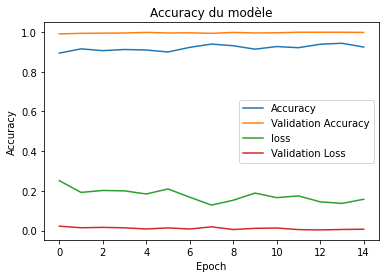

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Accuracy du modèle")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

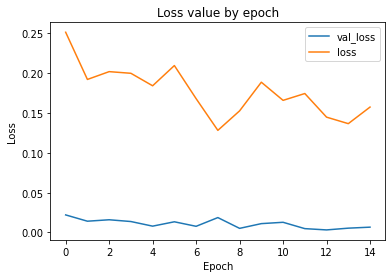

In [ ]:
plt.plot(history.history['val_loss'], label = "val_loss")
plt.plot(history.history['loss'], label = "loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(loc = "upper right")
plt.title("Loss value by epoch")

plt.show()

### Matrice de confusion

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)

y_test_arg =np.argmax(y_test,axis=1)
y_pred = np.argmax(predictions,axis=1)

cf_matrix =  confusion_matrix(y_test_arg, y_pred)
print(cf_matrix)

print(classification_report(y_test_arg, y_pred))

[[146   1]
 [  6 149]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       147
           1       0.99      0.96      0.98       155

    accuracy                           0.98       302
   macro avg       0.98      0.98      0.98       302
weighted avg       0.98      0.98      0.98       302



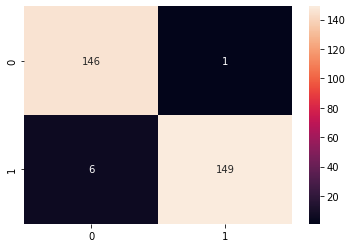

In [46]:
import seaborn as sns

sns.heatmap(cf_matrix, annot=True, fmt="d")

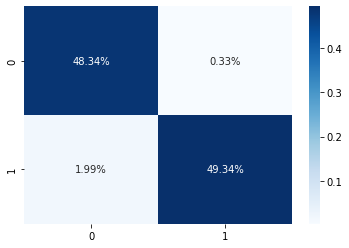

In [41]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

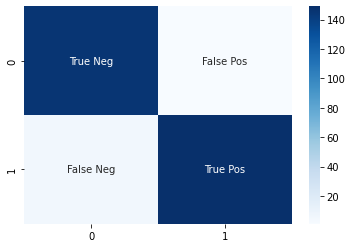

In [45]:
labels = ["True Neg","False Pos","False Neg" ,"True Pos" ]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

## Partie 3 : Application

In [ ]:
# cv2.putText(Img, message, (x, y), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))) 

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

img_path = '/content/drive/MyDrive/Jeff.PNG'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)



preds = model.predict(x)
pred = np.argmax(preds)
if pred == 0 :
  print("Sans masque")
else :
  print("Avec masque")



Sans masque
